In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [29]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
from statistics_methods.Statistics import StatisticsWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [4]:
def load_data(data_path, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    chosen_data = chosen_data.drop(columns=constants.SLOPES)
    chosen_data['ROI'] = chosen_data['ROI'].astype(int)
    chosen_data['subjects'] = chosen_data['subjects'].astype(str)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

In [5]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers=outliers)

# Cortex binary classification

In [24]:
data = chosen_data_raw.copy()
young_mask = young_subjects_raw.index
old_mask = old_subjects_raw.index

# Assign labels directly to data_reduced_tsne DataFrame
data.loc[young_mask, 'label'] = 0
data.loc[old_mask, 'label'] = 1

data = data.sample(frac=1)

x, y = data.drop(columns=['label']), data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=data['ROI_name'], random_state=42)

In [27]:
model = xgb.XGBClassifier(random_state=42)
model.fit(x_train[params_to_work_with], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [28]:
#Making predictions on the test set
predictions = model.predict(x_test[params_to_work_with])

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['young', 'old']))

Accuracy: 0.8918918918918919

Classification Report:
              precision    recall  f1-score   support

       young       0.89      0.92      0.90       185
         old       0.89      0.86      0.88       148

    accuracy                           0.89       333
   macro avg       0.89      0.89      0.89       333
weighted avg       0.89      0.89      0.89       333



In [32]:
# Add predictions to the test dataset
test_results = x_test.copy()
test_results["predicted_label"] = predictions
test_results["label"] = y_test

# Group by name and calculate evaluation metrics for each group
name_groups = test_results.groupby("ROI_name")
evaluation_results = []

for name, group in name_groups:
    true_labels = group["label"]
    predicted_labels = group["predicted_label"]
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    evaluation_results.append({
        "Name": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

# Convert evaluation results to DataFrame for easier visualization
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)

/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                               Name  Accuracy  Precision    Recall  F1-score
0    ctx-lh-caudalanteriorcingulate  1.000000   1.000000  1.000000  1.000000
1        ctx-lh-caudalmiddlefrontal  0.857143   1.000000  0.666667  0.800000
2                     ctx-lh-cuneus  0.714286   0.500000  1.000000  0.666667
3                   ctx-lh-fusiform  0.833333   1.000000  0.500000  0.666667
4           ctx-lh-inferiorparietal  1.000000   1.000000  1.000000  1.000000
5           ctx-lh-inferiortemporal  1.000000   1.000000  1.000000  1.000000
6                     ctx-lh-insula  1.000000   1.000000  1.000000  1.000000
7           ctx-lh-isthmuscingulate  1.000000   1.000000  1.000000  1.000000
8           ctx-lh-lateraloccipital  0.833333   0.666667  1.000000  0.800000
9       ctx-lh-lateralorbitofrontal  1.000000   1.000000  1.000000  1.000000
10                   ctx-lh-lingual  0.714286   0.600000  1.000000  0.750000
11       ctx-lh-medialorbitofrontal  0.833333   0.500000  1.000000  0.666667

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='gain', ylabel='Features'>

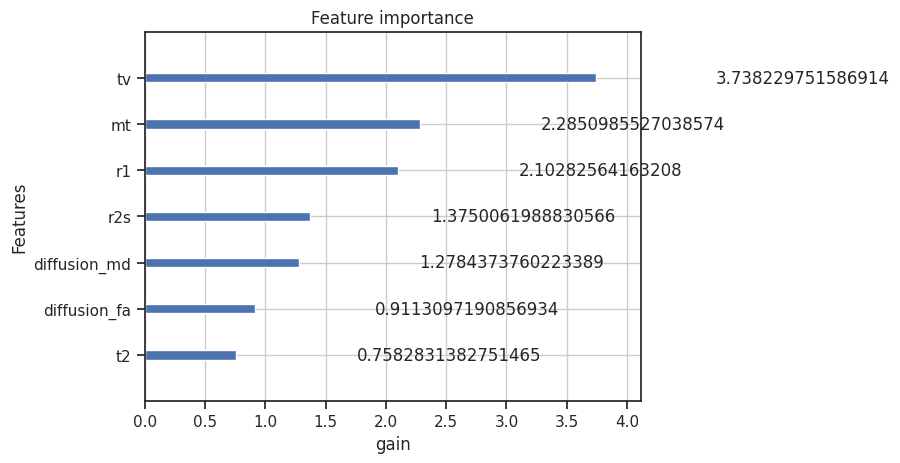

In [21]:
xgb.plot_importance(model, importance_type='gain', xlabel='gain')

## Age prediction

In [62]:
random_state = 2
data = chosen_data_raw.copy()
data = data.sample(frac=1, random_state=random_state)
x, y, rois_names = data[params_to_work_with], data['Age'], data['ROI_name']

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
model = xgb.XGBRegressor(random_state=random_state)

In [64]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

In [65]:
predictions = model.predict(x_test)
print(list(zip(predictions, y_test)))
# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error:", mae)

[(55.693653, 27), (42.354233, 75), (59.65962, 71), (29.254784, 26), (35.146004, 27), (63.545643, 71), (71.44532, 73), (49.976376, 31), (73.52811, 67), (68.65457, 69), (54.92716, 63), (56.263218, 24), (25.363031, 27), (64.122185, 75), (27.771519, 25), (35.45588, 27), (71.86218, 70), (28.074635, 27), (30.883078, 25), (27.698137, 24), (64.03692, 67), (54.66106, 25), (61.995033, 75), (65.8391, 73), (57.483994, 68), (60.916737, 70), (49.692066, 25), (28.228233, 26), (49.66526, 68), (24.187504, 26), (61.386795, 57), (24.357565, 23), (38.836376, 26), (37.27322, 31), (34.95636, 27), (22.986279, 24), (43.69463, 63), (59.935013, 63), (65.88038, 61), (30.99273, 25), (21.989063, 23), (61.323345, 69), (50.145603, 65), (64.5871, 65), (38.85093, 31), (61.346954, 65), (69.16276, 71), (32.09418, 23), (59.94082, 75), (23.318995, 26), (27.86271, 31), (61.012554, 69), (71.5111, 57), (63.845615, 69), (45.06087, 26), (40.412613, 25), (57.612232, 75), (36.28253, 27), (26.0125, 25), (58.420326, 69), (28.27571